# Test Predictor

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import imp
import json
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
#from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import glob
from datetime import datetime
import cv2 as cv


from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import dataset
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib

## Imp reload

In [2]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

## Initialize YOLOv4 detector

In [3]:
det = detector.Detector_v4()

Detector initiated successfully


## Load Data

In [3]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

46 trials loaded


(-507.76554708950636,
 2273.8644900137674,
 -395.23839888336073,
 3862.7752047072668)

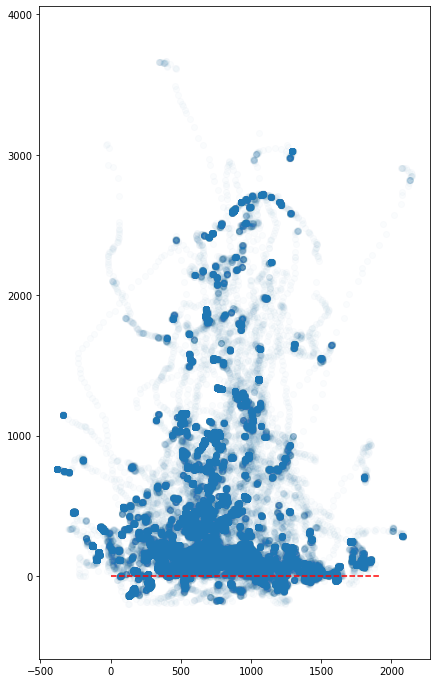

In [4]:
plt.figure(figsize=(7,12))
plt.scatter(all_df.x2,all_df.y2,alpha=0.02)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')

In [5]:
feeding_mask = all_df.index.str.contains('feeding')

In [6]:
all_df[feeding_mask].shape

(54008, 16)

In [7]:
feeding_df = all_df[feeding_mask]

## Train Seq2Seq Trajectory Predictor

In [8]:
# all trials (experiments + feeding)
all_trials = list(all_df.index.unique())
all_trials = list(filter(lambda trial: not all(all_df.loc[trial].x2.isna()),all_trials))

In [11]:
# only feeding trials
all_trials = list(feeding_df.index.unique())
all_trials = list(filter(lambda trial: not all(feeding_df.loc[trial].x2.isna()),all_trials))

In [9]:
results=[]
train, val, test = train_eval.create_train_val_test_splits(all_trials, [0.8, 0.2, 0])

In [346]:
train, val, test

(['feeding_4_20200830-125905_None',
  'line_20200803T114942_trial1',
  'beetle_fast_line_20200830T124020_trial1',
  'line_20200803T101641_trial2',
  'circle_20200803T115839_trial1',
  'line_20200803T081735_trial1',
  'feeding_4_screen_20200830-130446_None',
  'circle_20200803T093051_trial1',
  'cockroach_line_20200830T120130_trial1',
  'circle_20200803T084227_trial2',
  'circle_20200803T091639_trial1',
  'circle_20200803T090615_trial1',
  'worm_line_20200830T121513_trial1',
  'line_20200803T101641_trial1',
  'worm_line_20200830T122932_trial1',
  'cockroach_circle_20200830T123508_trial1',
  'circle_20200803T084227_trial1',
  'line_20200803T094928_trial1',
  'feeding_4_20200830-122515_None',
  'feeding_20200830-115520_None',
  'circle_20200803T084529_trial1',
  'line_20200803T095401_trial1',
  'circle_20200803T113121_trial1',
  'feeding_20200830-120813_None',
  'fast_cockroach_20200803T085738_trial1',
  'worm_line_20200830T120451_trial1',
  'worm_circle_20200830T122241_trial1',
  'worm_2

### Network parameters

In [10]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']
input_dim = len(input_labels)
output_dim = len(output_labels)

inp_seq_len = 20
out_seq_len = 20
embedding_size = 4  # only used in supporting models.
hidden_size = 350
rnn_layers = 1
dropout = 0.05

batch_size = 256

In [347]:
# Create dataloader for training
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(
    all_df, train, val, test, input_labels, output_labels, inp_seq_len, 
    out_seq_len, batch_size=batch_size, std_threshold=5, keep_lowvar_prob=0.2)

f"number of training samples: {len(train_dl) * batch_size}"

'number of training samples: 106496'

### Choose a seq2seq Model

In [818]:
"""
Network hyperparameters:
- in GRU and LSTM:
    - number of layers
    - hidden state dimension
    - embedding layer for the input
    - input and output length

Training parameters:
    - loss
    - type of optimizer
    - learning rate, schedueler
    - gradient clipping
    - batch size (does it matter?)
    - dropout
    - normalization/ standardization (?)
    - weight regularization (?) https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/


Data statistics:

"""

'\nNetwork hyperparameters:\n- in GRU and LSTM:\n    - number of layers\n    - hidden state dimension\n    - embedding layer for the input\n    - input and output length\n\nTraining parameters:\n    - loss\n    - type of optimizer\n    - learning rate, schedueler\n    - gradient clipping\n    - batch size (does it matter?)\n    - dropout\n    - normalization/ standardization (?)\n    - weight regularization (?) https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/\n\n\nData statistics:\n\n'

Problem:

With current data the models are not able to learn or generalize. The initial random weights 
score is not much than the test score achieved after several epochs. Also, the loss reaches saturation very fast
and the testing metric (ADE, FDE) only increase or reach saturation very fast.

- Models: tried 2 architechtures, LSTM-Dense and GRU-Enc-Dec, with various parameters.

- Training parameters: tried various training parameters. Could be that some specific configuration will lead to better result, but very hard to systematicly search for these parameters.

- Data: training with a single trial led to "normal" learning dynamics, which might indicate that there's no problem with the model. But still the model can't learn the entire dataset, and it's unclear what property of the dataset causes this. Maybe a different composition of sequences, or a larger and more consistent dataset would have worked. It's still unclear how and if more data will help. In the worst case, the data is just unlearnable for certain forecast horizons.

Possible things to try:

- New models and architechtures. 

- Add the cropped head image as extra input, with a part in the archtichture processing the image.

- More systematic hyperparameter and training parameters search.

- Other data pereperations, filtering, more data, etc.

In [591]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

In [132]:
model_type = 'LSTMdense'
net = seq2seq_predict.LSTMdense(out_seq_len, hidden_size=hidden_size, 
                     embedding_size=embedding_size, LSTM_layers=rnn_layers, dropout=dropout)

In [20]:
model_type = 'GRUEncDec'
net = seq2seq_predict.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                     tie_enc_dec=False, use_gru_cell=True, dropout=dropout)

In [173]:
model_type = 'GRUPositionEncDec'
net = seq2seq_predict.GRUPositionEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, embedding_size=embedding_size,
                             GRU_layers=rnn_layers, dropout=dropout)

In [1]:
model_type = 'VelLinear'
net = seq2seq_predict.VelLinear(input_size=input_dim, output_size=output_dim, input_seq_size=inp_seq_len, output_seq_size=out_seq_len, 
                     hidden_size=hidden_size, dropout=dropout)

NameError: name 'seq2seq_predict' is not defined

### Train

In [600]:
date = datetime.now().strftime('%m%d-%H%M')
model_name=f"{model_type}_{date}_i{inp_seq_len}_o{out_seq_len}_h{hidden_size}_b{batch_size}_l{rnn_layers}"

clip_grad_norm = 1.5
lr = 0.00005
epochs = 50
eval_freq = 5
epoch_print_freq = 5
save_each_eval_model = False
loss_fn = train_eval.calc_ADE
#loss_fn = train_eval.angle_norm_displacement_loss_fn([1,1])
best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(model=net, 
                                                                             train_dataloader=train_dl,
                                                                             test_dataloader=val_dl,
                                                                             epochs=epochs,
                                                                             path='Prediction/traj_models/',
                                                                             clip_grad_norm=clip_grad_norm,
                                                                             eval_freq=eval_freq,
                                                                             loss_fn=loss_fn,
                                                                             epoch_print_freq=epoch_print_freq,
                                                                             model_name=model_name,
                                                                             save_each_eval_model=save_each_eval_model,
                                                                             lr=lr)

results.append((losses, ADEs, FDEs, f"{model_type} h{hidden_size} i{inp_seq_len} o{out_seq_len} lr{lr}"))

### Eval epoch: 0, Test set mean ADE: 80.178, mean FDE: 156.999
Epoch: 0, avg loss: 35.189, epoch time: 5.527
### Eval epoch: 5, Test set mean ADE: 22.879, mean FDE: 38.677
Epoch: 5, avg loss: 24.125, epoch time: 5.494
### Eval epoch: 10, Test set mean ADE: 22.286, mean FDE: 38.007
Epoch: 10, avg loss: 23.612, epoch time: 5.614
### Eval epoch: 15, Test set mean ADE: 22.142, mean FDE: 37.876
Epoch: 15, avg loss: 23.184, epoch time: 5.598
### Eval epoch: 20, Test set mean ADE: 22.170, mean FDE: 38.057
Epoch: 20, avg loss: 22.747, epoch time: 5.662
### Eval epoch: 25, Test set mean ADE: 22.209, mean FDE: 38.258
Epoch: 25, avg loss: 22.265, epoch time: 5.585
### Eval epoch: 30, Test set mean ADE: 22.325, mean FDE: 38.487
Epoch: 30, avg loss: 21.829, epoch time: 5.626
### Eval epoch: 35, Test set mean ADE: 22.612, mean FDE: 39.240
Epoch: 35, avg loss: 21.415, epoch time: 5.514


KeyboardInterrupt: 

### Display results

In [49]:
results = pickle.load(open("Prediction/traj_models/overfit-3ksamps-results.p", "rb"))

In [100]:
pickle.dump(results, open(f"Prediction/traj_models/GRU_&LSTM_metrics_{date}.p", 'wb'))

In [17]:
def plot_train_results(results_list, title):
    fig, axs = plt.subplots(3, figsize=(10,20))
    fig.suptitle(title)

    axs[0].set_ylabel("ADE")
    axs[1].set_ylabel("FDE")
    axs[2].set_ylabel("loss")
    
    for (losses, ADEs, FDEs, name) in results_list:
        if 'LSTM' in name:
            lstyle = '--'
        else:
            lstyle = '-'
        axs[0].plot(list(ADEs.values()), label=name, linestyle=lstyle)
        #axs[0].legend()
        axs[1].plot(list(FDEs.values()), label=name, linestyle=lstyle)
        #axs[1].legend()
        #axs[0].set_xticklabels(np.ar)
        axs[2].plot(losses, label=name, linestyle=lstyle)
        axs[2].legend()        

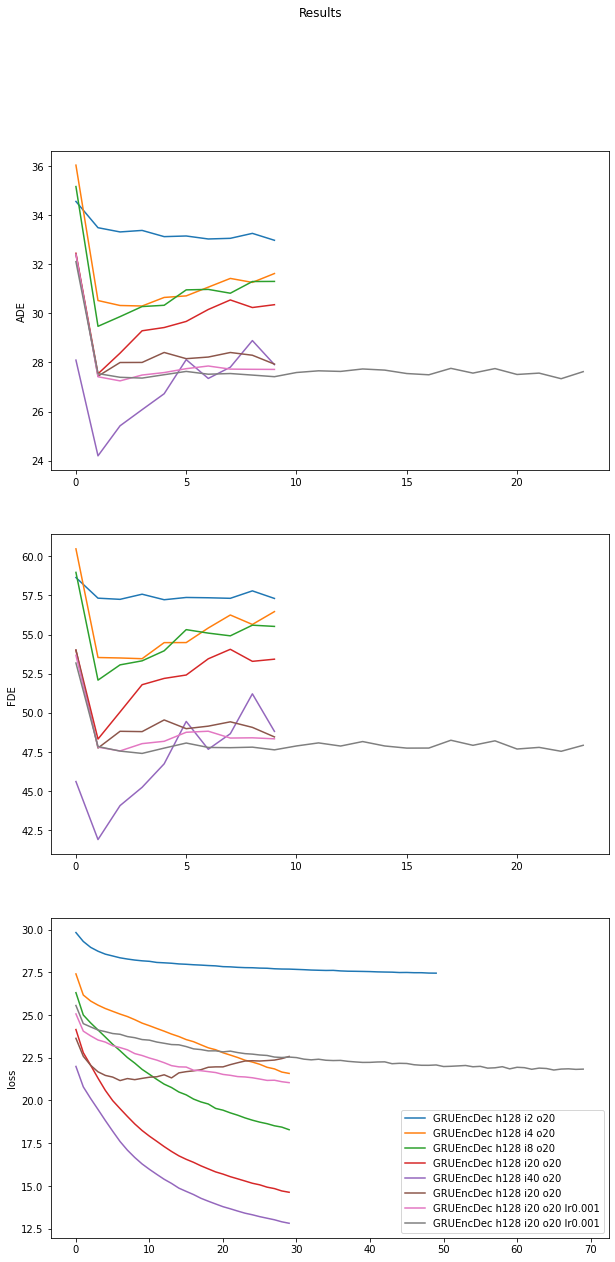

In [60]:
plot_train_results(results, "Results")

### AX Hyperparameter tuning

In [3]:
# https://ax.dev/tutorials/tune_cnn.html
import torch
import numpy as np

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

init_notebook_plotting()


In [59]:
HP_JSON = 'Prediction/traj_models/0_models_hps.json'

def update_hp_json(model_name, model_params_dict):
    if os.path.exists(HP_JSON):
        with open(HP_JSON, 'r') as fp:
            json_dict = json.load(fp)
    else:
        json_dict = dict()
        
    json_dict[model_name] = model_params_dict
    
    with open(HP_JSON, 'w') as fp:
        json.dump(json_dict, fp)


In [96]:
inp_seq_len = 20
out_seq_len = 20
embedding_size = None  # only used in supporting models.
#hidden_size = 128
#rnn_layers = 1

In [103]:
def train_evaluate(params):
    print(params)
    
    date = datetime.now().strftime('%m%d-%H%M%S')
    model_type = 'GRUEncDec'
    
    epochs = 100
    eval_freq = 5
    epoch_print_freq = 10000
    save_each_eval_model = False    
    
    rnn_layers = 1
    
    hidden_size = params['hidden_size']
    #rnn_layers = params['rnn_layers']
    dropout = params['dropout']
    clip_grad_norm = params['clip_grad_norm']
    lr = params['lr']
    
    model_name=f"{model_type}_{date}_i{inp_seq_len}_o{out_seq_len}_b{batch_size}"    
    net = seq2seq_predict.GRUEncDec(output_seq_size=out_seq_len,
                                hidden_size=hidden_size, 
                                GRU_layers=rnn_layers,
                                tie_enc_dec=False, 
                                use_gru_cell=True, 
                                dropout=dropout)

    best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(model=net, 
                                                                                 train_dataloader=train_dl,
                                                                                 test_dataloader=val_dl,
                                                                                 epochs=epochs,
                                                                                 path='Prediction/traj_models/',
                                                                                 clip_grad_norm=clip_grad_norm,
                                                                                 eval_freq=eval_freq,
                                                                                 epoch_print_freq=epoch_print_freq,
                                                                                 model_name=model_name,
                                                                                 save_each_eval_model=save_each_eval_model,
                                                                                 lr=lr)
    params['best_epoch'] = best_epoch
    params['best_ADE'] = best_ADE
    params['best_ADE_epoch_loss'] = losses[best_epoch]
    params['rnn_layers'] = rnn_layers
    
    update_hp_json(model_name, params)
    
    return best_ADE

def train_evaluate2(params):
    return np.random.normal()

In [104]:
parameters=[
    {"name": "lr", "type": "range", "bounds": [0.00001, 0.01], "log_scale": True},
    {"name": "hidden_size", "type": "range", "bounds": [32, 384]},
    {"name": "dropout", "type": "range", "bounds": [0.0, 0.75]},
    #{"name": "rnn_layers", "type": "range", "bounds": [1, 3]},
    {"name": "clip_grad_norm", "type": "range", "bounds": [0.5, 10.0]}
    ]


In [ ]:
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=train_evaluate,
    objective_name='ADE',
    total_trials=50, 
    minimize=True)

[INFO 09-15 19:56:21] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 09-15 19:56:21] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 09-15 19:56:21] ax.service.managed_loop: Running optimization trial 1...


{'lr': 4.37555406410694e-05, 'hidden_size': 382, 'dropout': 0.4775395926553756, 'clip_grad_norm': 1.6149856802076101}
### Eval epoch: 0, Test set mean ADE: 33.967, mean FDE: 56.638
Epoch: 1, avg loss: 25.699, epoch time: 9.716
### Eval epoch: 5, Test set mean ADE: 27.196, mean FDE: 47.054
### Eval epoch: 10, Test set mean ADE: 26.863, mean FDE: 46.844
### Eval epoch: 15, Test set mean ADE: 26.725, mean FDE: 46.581
### Eval epoch: 20, Test set mean ADE: 26.655, mean FDE: 46.544
### Eval epoch: 25, Test set mean ADE: 26.641, mean FDE: 46.559
### Eval epoch: 30, Test set mean ADE: 26.552, mean FDE: 46.312


In [106]:
values

({'ADE': 26.06375928337079}, {'ADE': {'ADE': 9.524271687552747e-09}})

In [107]:
best_parameters

{'lr': 6.591781359510046e-05,
 'hidden_size': 350,
 'dropout': 9.133681056711136e-05,
 'clip_grad_norm': 1.343065509441185}

#### Ax Results

- values = ({'ADE': 26.06375928337079}, {'ADE': {'ADE': 9.524271687552747e-09}})
- best_parameters = {'lr': 6.591781359510046e-05,
 'hidden_size': 350,
 'dropout': 9.133681056711136e-05,
 'clip_grad_norm': 1.343065509441185}

## Test Predictors

In [49]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

In [12]:
# Kalman Trajectory Predictor
traj_predictor = kalman_predict.KalmanPredictor(forecast_horizon=20, num_derivatives=1, q_var=0.3, r_var=1.0)

In [65]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']
input_dim = len(input_labels)
output_dim = len(output_labels)

inp_seq_len = 20
out_seq_len = 20
embedding_size = 4  # only used in supporting models.
hidden_size = 350
rnn_layers = 1
dropout = 0.2

batch_size = 256

In [13]:
model_type = 'GRUEncDec'
net = seq2seq_predict.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                     tie_enc_dec=False, use_gru_cell=True, dropout=dropout)

In [21]:
# Seq2Seq Trajectory Predictor
#model_path = 'Prediction/traj_models/model_20_20_h64_b128_l1_LSTMdense_c1_36_best.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_0915-1624_i20_o20_h128_b128_l1_66_best.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_0916-034907_i20_o20_b128_10_best.pth' # ax best
#model_path = 'Prediction/traj_models/GRUEncDec_0921-1559_i20_o20_h350_b256_l1_15_best.pth'
model_path = 'Prediction/traj_models/GRUEncDec_rndloss_0921-1912_i20_o20_h350_b256_l1_20_best.pth'

traj_predictor = seq2seq_predict.Seq2SeqPredictor(net, model_path, 20, 20)

In [15]:
hit_predictor = predictor.HitPredictor(traj_predictor, detector=None, history_size=5288)

### Visualize Predictor

In [79]:
def get_exp_trial_folder(trial_name):
    exp_name, trialk = '_'.join(trial_name.split('_')[:-1]), trial_name.split('_')[-1]
    paths = glob.glob(os.path.join(dataset.EXPERIMENTS_ROOT, exp_name, trialk,'videos/*'))
    return paths[0]+'/'

In [80]:
# get trial path from experiment or output folder

trial = val[0]
#trial_path = os.path.join(dataset.OUTPUT_ROOT, '_'.join(trial.split('_')[:-1]))
trial_path = get_exp_trial_folder(trial) # in cast it's an experiment trial

if not os.path.exists(trial_path):
    print(f"Warning, {trial_path} does not exist")

In [81]:
vid_path = os.path.join(trial_path, '19506468.avi')
json_path = os.path.join(trial_path,'rt_data/vid_stats.json')



with open(json_path,'r') as f:
    vid_stats = json.load(f)

homography = np.array(vid_stats['homography'])
    
bboxes = all_df.loc[trial][['x1','y1','x2','y2']].values
out_name = "red_feeding_h64"
out_path = f"../labelled/{out_name}.mp4"

hit_predictor.reset(history_size=5288)
correction_fn = visualize.get_correction_fn(homography,1920)

In [124]:
visualize.process_video(video_path=vid_path,
                        output_path=out_path,
                        process_fns=[visualize.offline_predictor_visualizer(red_hitp,bboxes)],
                        correction_fn = correction_fn,
                        resize_to_width=540)

### Evaluate trajectory predictor

In [13]:
lots_o_touches = 'circle_20200803T115839_trial1'
lots_o_touches2 = 'fast_cockroach_20200803T085738_trial1'

In [27]:
#trial_data = val[1]
trial_data = lots_o_touches2
bboxes = all_df.loc[trial_data][['x1','y1','x2','y2']].values

FIRST_FRAME = 0

bboxes = bboxes[FIRST_FRAME:] 
# TODO - slicing bbox array creates a discrepency between the forecasts and the dataframe?
# might 
#bboxes[60:70] = np.nan
eval_results, forecasts = train_eval.eval_trajectory_predictor(traj_predictor, bboxes)
eval_results

100%|██████████| 5061/5061 [00:00<00:00, 10480.57it/s]


{'avg ADE': 58.66544970000952,
 'avg FDE': 141.6786661348155,
 'avg time (ms)': 2.7656455228610715}

- gru = 4.78/8.46 (3.8ms)
- grucell = (3.14ms or even lower)
- red = 4.88/8.62 (0.6ms)
- vel_linear = 4.91/8.72 (0.2ms)
- kalman = 6.8852/13.116 (0.09ms)

#### Plot real path, predicted path, and connecting lines between them
n determines the forecast timestep used to generate the predicted path.

In [28]:
def gen_forecasts_path(forecasts, n=0):
    # first_forecast - the first forecast which doesn't contain any np.nan
    first_forecast = next(i for i, fc in enumerate(forecasts) if fc is not None and not np.any(np.isnan(fc)))
    path = np.empty((len(forecasts) - first_forecast - 1, 4))
    # create the entire path from the forecasts
    for i in range(path.shape[0]):
        path[i] = forecasts[first_forecast + i][n]
    return path, first_forecast

5060 5081 20 5081 5081
fast_cockroach_20200803T085738_trial1


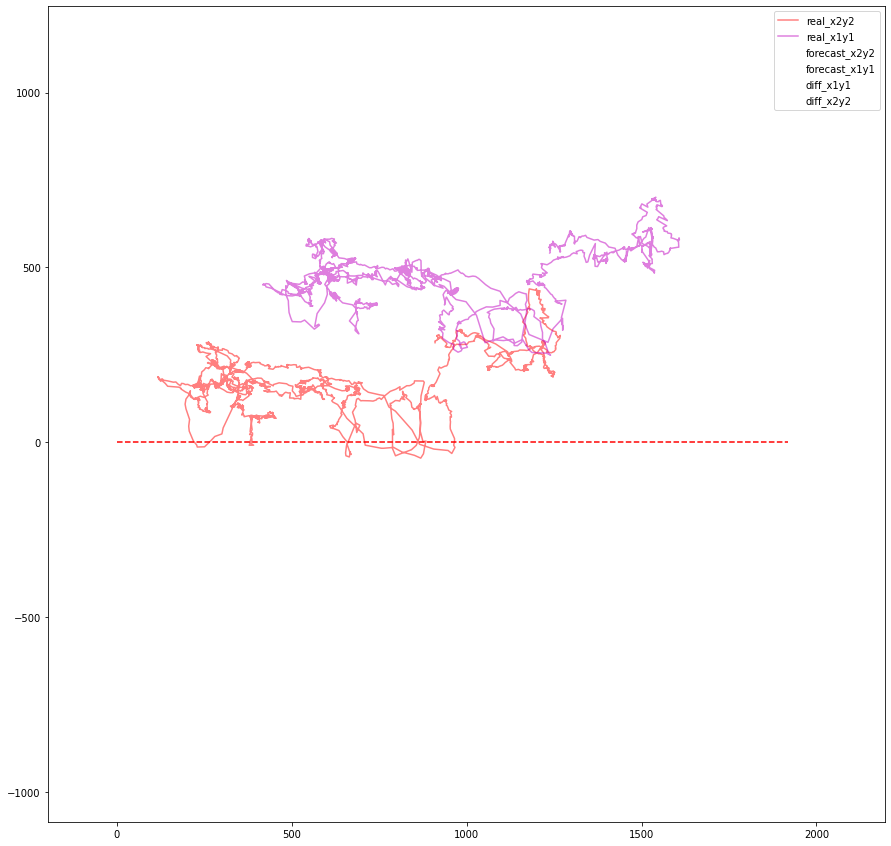

In [29]:
X1, Y1, X2, Y2 = 0, 1, 2, 3

# TODO - maybe function
n = 10
fpath, first_f = gen_forecasts_path(forecasts, n=n)
fpath = np.roll(fpath, n+1, axis=0)
fpath[:n+1] = np.nan
rpath = bboxes #[first_f+1:]

fig, ax = plt.subplots(figsize=(15,15))
ax.axis('equal')

# change these parameters to inspect only a single path and make the others less visible
# can also use zorder paramater to control the oreder of plots
real_alpha = 0.5
fore_alpha = 0.0
diff_alpha = 0.0

# plot top left, bottom right coordinates of recorded path
ax.plot(rpath[:, X2], rpath[:, Y2], color="r" ,label = 'real_x2y2', alpha=real_alpha)
ax.plot(rpath[:, X1], rpath[:, Y1], color="m", label = 'real_x1y1', alpha=real_alpha)

# plot top left, bottom right coordinates of predicted path
ax.plot(fpath[:, X2], fpath[:, Y2], color="c",label = 'forecast_x2y2', alpha=fore_alpha)
ax.plot(fpath[:, X1], fpath[:, Y1], color="b",label = 'forecast_x1y1', alpha=fore_alpha)

print(len(fpath), len(rpath), first_f, len(forecasts), len(bboxes))
lines = np.stack([fpath[:, 0:2], rpath[first_f+1:, 0:2]], axis=1)
ax.add_collection(LineCollection(lines, colors=['r'],alpha=diff_alpha, label = "diff_x1y1"))

lines2 = np.stack([fpath[:, 2:4], rpath[first_f+1:, 2:4]], axis=1)
ax.add_collection(LineCollection(lines2, colors=['orange'], alpha=diff_alpha, label = "diff_x2y2"))
#ax.set_xlim([0,1920])
#ax.set_ylim([-200,3500])
ax.plot(np.linspace(0,1920,num=5),np.zeros(5),linestyle='--', color='r')

ax.legend()
print(trial_data)

### Plot all predictions of each timestep

In [ ]:
"""
A thought about this visualization - it's optimistic, becuase shroter time intervals provide
more accurate predictions.
Idea - take the mean prediction, over an interval that does include the shortest predictions.
i.e, take the mean prediction over all predictions from (-20) to (-10).
"""

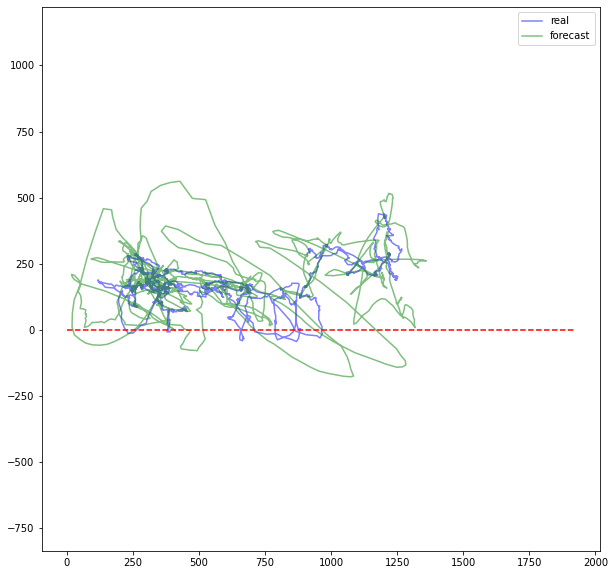

In [30]:
def predictions_per_step(forecasts):
    first_forecast = next(i for i, fc in enumerate(forecasts) if fc is not None)
    forecast_len = forecasts[first_forecast].shape[0]
    preds = np.empty((len(forecasts) - first_forecast, forecast_len, 4))
    preds[:] = np.nan
    
    for i in range(preds.shape[0]):
        for j in range(max(0, i - forecast_len+1), i+1):
            f = forecasts[j]
            if f is not None:
                preds[i, i-j] = f[i-j]
    
    return preds

real_alpha = 0.5
fore_alpha = 0.5

preds = predictions_per_step(forecasts)
avgs = np.mean(preds, axis=1)
rpath = bboxes[first_f+1:]
npath = preds[:, 0]
plt.figure(figsize=(10,10))
plt.plot(rpath[:, X2], rpath[:, Y2], color='b', alpha=real_alpha, label='real')
plt.plot(avgs[:, X2], avgs[:, Y2], color='g',alpha=fore_alpha, label='forecast')
#plt.plot(npath[:, 0], npath[:, 1], color='r')
plt.axis('equal')
plt.legend()
plt.plot(np.linspace(0,1920,num=5),np.zeros(5),linestyle='--', color='r')


#### Problems
- it's not clear what is the timestep of the first forecast.
- How should we deal with discontinuities in KalmanPredictor? currently the filter is reinitialized. Otherwise I saw crazy predictions

### Evaluate Hit Predictor

In [ ]:
"""
Hit Prediction Evalutaion:
For a trial with hit events, need to implement a function that outputs a structure that 
saves for each frame with a hit event, the forecasts that predicted a hit that occurs in that frame,
and the x values of every such prediction. The rationale for saving all of the forecasts that predicted a hit in a certain frame
is the that good predictions will ideally converge over consecutive forecasts.

Structure:
For each frame in the video, create an array with dimensions forecast_horizon X 2 
(maybe just a 3d array, something like in predictions_per_step, and also save the x values)
Other idea - 2d array, (num_frames) X (forecast_horizon)

Functions:
Iterate over forecasts which are not None, and threshold y2 values against y=0 in the arena (or some other y value).
If a bbox crosses the threshold for some forecast, save the index of the first crossing in the forecast, as a value in the relevant index of the frame.
For example, if the forecast_horizon is 20, and forecast 1000 (started from frame 1000) predicts a hit in it's 10 timestamp,
save the x value in index 10 in frame 1010. If forecast 1001 predicts an hit in it's 9th timestamp, save the value in index 9 in fram 1010.
Notice: for each frame, there are 20 indices: index 0 means that a forecast predicted a hit one frame in advance, index 8 means 12 frames in advance.

frame | forecast_0 | forecast_1 | ... | forecast_19
____________________________________________________
    0 | nan        |   x_1      | ... |    x_19    
    1 | x_0        |   x_1      | ... |    nan
    ....

from this, maybe a smaller array with columns "frame | num_forecasts_predicted_hit | mean_x_value"

Visualization:
A horizontal indexed heatmap, where each timestamp is colored by the amount of forecasts that predict a hit
in that frame. On the same figure, plot with other colors the real hit events. 
It's a sort of a "raster plot".
Matplotlib function: "eventplot"
Also possible to generate a raster plot for each forecast seperatly - idealy, a hit event should be preceeded by a diagonal
pattern of predicted hits

# TODO
Maybe other visualiztions that combine the temporal data with the arena coordinates data.

Metrics - TODO:
We can compare that structure to the real frames that have an actual hit event and their respective x values,
and calculate various metrics that quantify the errors. Join the the arrays.
FN - missed an hit event (by how much?)
FP - predicted an hit event by mistake (relative to what ground truth events?)
Other issues: how to decide what is a "close" event? what to do if there are many? etc...
- TODO
"""


In [31]:
# TODO: aligning with true touching events won't work, check FIRST_FRAME parameter from evaluate trajectory predictor cell

def get_hit_preds_forecasts(forecasts_list, 
                            hit_pred, 
                            y_thresh=0,
                            preds_forecasts=True,
                            return_mean=False):
    """
    Receive a forecasts list, and generate an array describing the hit predictions from the frame perspective,
    i.e, for each frame, there's a forecast_horizon shape row, with a value in the index of a forecast that 
    predicted a hit. (if forecast 1234 predicted hit in 5 frames, then pred[1239,5] has a value).
    
    if pred_forecasts is False, will return the opposite array of get_hit_preds_forecasts: 
    describes for each forecast, at which index they first predict a hit
    
    If return_mean is true, will count the number of forecasts predicting a hit for a specific frame, and the mean predicted
    x value.
    """
    if hit_pred.prediction_y_threshold != y_thresh:
        print(f"changed hit predictor y's thresh from {hit_pred.prediction_y_threshold} to {y_thresh}")
        hit_pred.prediction_y_threshold = y_thresh
    
    first_forecast = next(i for i, fc in enumerate(forecasts) if fc is not None) # if no forecasts, still return zero?
    if forecasts_list[first_forecast] is None:
        print("No forecasts in list")
        return
    
    forecast_horizon = forecasts_list[first_forecast].shape[0]
    preds = np.empty((len(forecasts_list), forecast_horizon))    
    preds[:] = np.nan
    
    for i, forecast in enumerate(forecasts_list[first_forecast:-forecast_horizon]):
        x2, hit_ind = hit_pred.predict_hit(forecast)
        if hit_ind is not None and hit_ind < preds.shape[0]:
            if preds_forecasts:
                frame_ind = first_forecast + (i+1) + hit_ind #  the frame index to which the hit is predicted
                preds[frame_ind, hit_ind] = x2  # place the x value in the index that the forecast predicted
            else:
                forecast_ind = first_forecast + (i+1) #  the forecast index which predicts the hit
                preds[forecast_ind, hit_ind] = x2  # place the x value in the index that the forecast predicted
    
    if preds_forecasts:
        if return_mean:
            temp = np.empty((preds.shape[0], 2))
            temp[:,0] = (~np.isnan(preds)).sum(axis=1) # number of forecasts predicting hit
            temp[:, 1] = np.nanmean(preds,axis=1)
            return temp
    return preds


def plot_preds_and_truth(preds, 
                         trial_slice, 
                         ax,
                         start=None, 
                         end=None,):
    """
    preds - a frame prediction array
    trial_slice - the slice from the dataframe for that trial, sliced like the bboxes array
    which the traj predictor operated on.
    Caller's responsibility to make sure the arrays are the same shape on dim 0 and that 
    they are aligned.
    """
    
    hits = False
    
    if start is None:
        start = 0
    if end is None:
        end = preds.shape[0]
    
    ax.set_xticklabels(np.arange(start=start, stop=end+1)) # ax.set_xticks set the integer indices of the labels
    
    preds = preds[start:end]
    trial_slice = trial_slice.iloc[start:end]
    
    forecast_horizon = preds.shape[1]
    if trial_slice is not None:
        hits_idx = np.where(trial_slice.is_touch)[0]
    
        if hits_idx.shape[0] == 0:
            print("no real hits")
        else:
            hits = True
    
    if np.all(np.isnan(preds)):
        print("All nan, nothing to show")
        return
    sns.heatmap(preds.transpose(), ax=ax)
        
    curr_x_ticks = list(ax.xaxis.get_ticklabels())
    stride = int(curr_x_ticks[1].get_text())
    ax.set_xticklabels(np.arange(start=start, stop=end+1,step=stride), rotation=30) # ax.set_xticks set the integer indices of the labels
    tick_freq = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % tick_freq != 0:
            label.set_visible(False)
        
    if hits:
        for x in hits_idx:
            ax.plot(np.ones(2)*x, np.linspace(0,20,num=2), linestyle='--',linewidth=1.5, color='g') 
    
   

In [32]:
y_thrsh = 0

In [33]:
hit_preds = get_hit_preds_forecasts(forecasts_list=forecasts,
                                    hit_pred=hit_predictor,
                                    y_thresh=y_thrsh,
                                    return_mean=False)

In [34]:
forecast_preds = get_hit_preds_forecasts(forecasts_list=forecasts,
                                    hit_pred=hit_predictor,
                                    y_thresh=y_thrsh,
                                    preds_forecasts=False,
                                    return_mean=False)

In [35]:
hit_preds.shape

(5081, 20)

In [295]:
start = 1700
end = 2000
fs = 20
pad = 40

Text(0.5, 1.0, 'Predictions of hit at frame $k$ (x) made $m$ timesteps ago (y)')

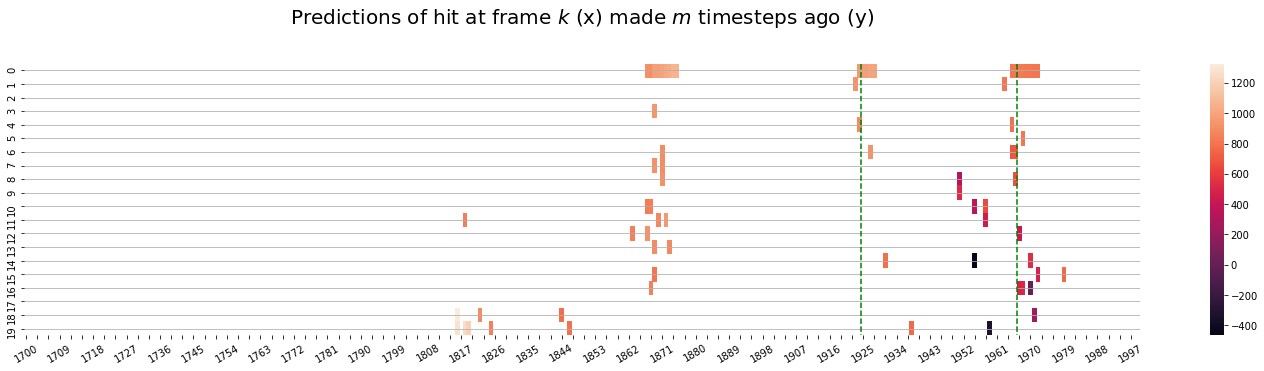

In [296]:
fig, ax1 = plt.subplots(1,1,figsize=(25,5))
plot_preds_and_truth(hit_preds,
                     all_df.loc[trial_data],
                     ax1,
                     start=start,
                     end=end)
plt.grid(axis='y')
plt.title("Predictions of hit at frame $k$ (x) made $m$ timesteps ago (y)", fontsize=fs, pad=pad)

Text(0.5, 1.0, 'Predictions of forecasts made at frame $k$ (x) to hit in $m$ timesteps (y)')

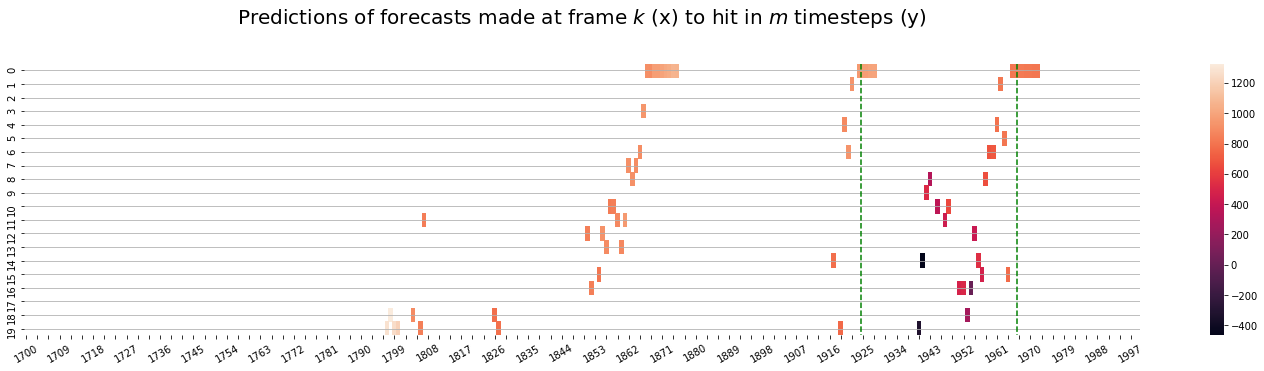

In [297]:
fig, ax2 = plt.subplots(1,1,figsize=(25,5))
plot_preds_and_truth(forecast_preds,
                     all_df.loc[trial_data],
                     ax2,
                     start=start,
                     end=end)
plt.grid(axis='y')
plt.title("Predictions of forecasts made at frame $k$ (x) to hit in $m$ timesteps (y)", fontsize=fs, pad=pad)


In [210]:
# old function, not important
def get_k_before_hits(df,k):
    """
    for each index of a hit row, slice the k>=1 previous rows (including hit) as a multiindex dataframe 
    with triple index: experiment, trial, hit-event. concatenate dataframes vertically
    TODO: COMPLETE DOC
    TODO: Move to Dataset module
    """
    assert type(k)==int
    assert k>0
    
    df_list = []
    for trial in df.index.unique():
        temp = df.loc[trial]
        temp = temp.is_touch
        
        if temp.sum() == 0:
            continue
        hits_ind = np.where(temp)[0]
        #display(hits_ind)
        #return
        event_list = []
        for j, hit_ind in enumerate(hits_ind):
            if j==0:
                min_slice = np.max([0,hit_ind-k])
            else:
                min_slice = np.max([0,hit_ind-k,hits_ind[j-1]])
            max_slice = hit_ind + 1
            sliced_event = df.loc[trial].iloc[min_slice:max_slice]
            #sliced_event.index = pd.MultiIndex.from_tuples([(trial[0], trial[1], j) for k in range(sliced_event.shape[0])])
            event_list.append(sliced_event)
        
        df_list.append(pd.concat(event_list))
    return pd.concat(df_list)

    

### Sequences data analysis

Some general suggestions posts regarding training and generalization:
- https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn#

Most of the post deals with verifying the the correcteness of the data and the architecture. It doesn't seem that our network and\or data is malfunctioning.

- https://stats.stackexchange.com/questions/365778/what-should-i-do-when-my-neural-network-doesnt-generalize-well 

Dropout - in more layers 

Transfer learning from other movement dataset or even some language dataset? 

Data augmentation - take a smaller and more well chosen dataset, and expand it? maybe apply some linear transformations on the data, to both make the generalization better and have more data. Train a single model multiple times (or interchangingly) with diffrent input sequnce lengths - the weights don't change? filtering before training - applying an MA filter on the path will cause it to be less noisy, capturing the essential trend.

More regularization?

Early stopping - wev'e been doing it anyway, maybe make more concrete.

Generalization and metrics - what is a resonable validation/test error?  

In [22]:
inp_seq_len = 20
out_seq_len = 20

In [23]:
train, val, test = train_eval.create_train_val_test_splits(all_trials, [1, 0, 0])

In [43]:
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(df=all_df, 
                                                                         train=train, val=val, test=test, 
                                                                         input_labels=input_labels, output_labels=output_labels,
                                                                         input_seq_size=inp_seq_len,output_seq_size=out_seq_len, 
                                                                         batch_size=batch_size, 
                                                                         std_threshold=0, keep_lowvar_prob=0.2,
                                                                         shuffle=False)                                                                        

In [41]:
""" 
TODO - Sequence level prediction? create seq_data_Yhat - the same dimensions as seq_data_Y. 
How to batch predict? and only on the test set?
"""
def get_seq_forecast(dataloader, traj_pred):
    forecasts_list = []
    
    with torch.no_grad():
        for x, y in dataloader:
            y_hat = traj_pred.model(x.to(traj_pred.model.device)).cpu().numpy()
            forecasts_list.append(y_hat)
    return np.concatenate(forecasts_list)

#### Sequence filtering

In [44]:
#seq_data_X = np.concatenate([train_dl.dataset.X.numpy()[:,:,2:], val_dl.dataset.X.numpy()[:,:,2:]])
#seq_data_Y = np.concatenate([train_dl.dataset.Y.numpy()[:,:,2:], val_dl.dataset.Y.numpy()[:,:,2:]])

# take x2y2

#dl = val_dl
dl = train_dl
seq_data_X = dl.dataset.X.numpy()[:,:,2:]
seq_data_Y = dl.dataset.Y.numpy()[:,:,2:]

seq_data_pred = get_seq_forecast(train_dl, traj_predictor)
seq_data_pred = seq_data_pred[:,:,2:]

print(f'{seq_data_X.shape[0]:,} sequences')

234,134 sequences


In [61]:
# velocities column - 2
if seq_data_X.shape[2]==3:
    print("velocity already exists")
else:
    seq_data_X = np.concatenate([seq_data_X,compute_velocities(seq_data_X).reshape(seq_data_X.shape[0],seq_data_X.shape[1],-1)],axis=2)
    seq_data_Y = np.concatenate([seq_data_Y,compute_velocities(seq_data_Y).reshape(seq_data_Y.shape[0],seq_data_Y.shape[1],-1)],axis=2)
    seq_data_pred = np.concatenate([seq_data_pred,compute_velocities(seq_data_pred).reshape(seq_data_pred.shape[0],seq_data_pred.shape[1],-1)],axis=2)

In [29]:

def mask_by_dist(seq_data,dist_func):
    # seq_data is a 3d array, #seq, #sequnce index, #xy
    dists = compute_dists(seq_data)
    return dist_func(dists)

In [30]:
# filter sequences by euclidean distance between first and last point

min_dist = 30
max_dist = 200

mask_dist_X = mask_by_dist(seq_data_X, dist_func=lambda x: (x > min_dist) & (x < max_dist))
mask_dist_Y = mask_by_dist(seq_data_Y, dist_func=lambda x: (x > min_dist) & (x < max_dist))
mask_dist_pred = mask_by_dist(seq_data_pred, dist_func=lambda x: (x > min_dist) & (x < max_dist))

#mask = mask_dist_X & mask_dist_Y
mask = mask_dist_Y

mask_source = 'L2 Distance'

In [ ]:
def compute_dists(seq_data):
    return np.linalg.norm(seq_data[:,-1]-seq_data[:,0],axis=1)

def mask_fl_dist(min_dist, max_dist, by_X=True, by_Y=True):
    def f(X, Y):
        dists_X = compute_dists(X[:,:,:2])
        dists_Y = compute_dists(Y[:,:,:2])
        
        ret_mask = np.array([True]*X.shape[0])
        
        if by_X:
            ret_mask = ret_mask & ((dists_X > min_dist) & (dists_X < max_dist))
        if by_Y:
            ret_mask = ret_mask & ((dists_Y > min_dist) & (dists_Y < max_dist))
        return ret_mask
    return f

In [ ]:
def compute_velocities(seq_data):
    num_seqs = seq_data.shape[0]
    nan_arr = np.tile(np.array([np.nan,np.nan]),(num_seqs,1)).reshape(num_seqs,1,2)
    return np.linalg.norm(np.concatenate([nan_arr,np.diff(seq_data,axis=1)],axis=1),axis=2)

In [31]:
# filter sequences by mean velocity of sequence

min_vel = 12
max_vel = 16

mean_vels_X = np.nanmean(seq_data_X[:,:,2],axis=1)
mean_vels_Y = np.nanmean(seq_data_Y[:,:,2],axis=1)
mean_vels_pred = np.nanmean(seq_data_pred[:,:,2],axis=1)

mask_vel_X = (mean_vels_X > min_vel) & (mean_vels_X < max_vel)
mask_vel_Y = (mean_vels_Y > min_vel) & (mean_vels_Y < max_vel)
mask_vel_pred = (mean_vels_pred > min_vel) & (mean_vels_pred < max_vel)


mask = mask_vel_X & mask_vel_Y

mask_source = 'Mean velocity'

In [65]:
compute_velocities(seq_data_X[:2,:,:2]).shape

(2, 19)

In [76]:
def compute_speeds(seq_data):
    return np.linalg.norm(np.diff(seq_data,axis=1),axis=2).mean(axis=1)

def mask_speed(min_speed, max_speed, by_X=True, by_Y=True):
    def f(X, Y):
        speeds_X = compute_speeds(X[:,:,:2])
        speeds_Y = compute_speeds(Y[:,:,:2])
        
        ret_mask = np.array([True]*X.shape[0])
        
        if by_X:
            ret_mask = ret_mask & ((speeds_X > min_speed) & (speeds_X < max_speed))
        if by_Y:
            ret_mask = ret_mask & ((speeds_Y > min_speed) & (speeds_Y < max_speed))
        return ret_mask
    return f

In [77]:
mask_fl_dist(1,100)(seq_data_X,seq_data_Y).sum()

168502

In [78]:
mask_speed(4,10,True,True)(seq_data_X, seq_data_Y).sum()

25721

In [109]:
3.6 % 3.2 +0.0000000000000001

0.4

In [113]:
True if 2>3 else False

False

In [154]:
def compute_zigzagity(seq_data):
    x_diffs = seq_data[:,1:] - seq_data[:,:-1]
    x_angle = np.arctan(x_diffs[:,:, 1] / x_diffs[:,:, 0])
    print(x_angle)
    x_angle_diffs = x_angle[:,1:] - x_angle[:,:-1]
    print(x_angle_diffs)
    abs_angle_diffs = np.abs(x_angle_diffs) % (2 * np.pi)
    print(abs_angle_diffs)
    pi_mask = abs_angle_diffs > np.pi
    abs_angle_diffs[pi_mask] = (2 * np.pi) - abs_angle_diffs[pi_mask] 
    print(abs_angle_diffs)
    return abs_angle_diffs.sum(axis=1)

def mask_zgzg(min_zgzg, max_zgzg, by_X=True, by_Y=True):
    def f(X, Y):
        zgzgs_X = compute_zigzagity(X[:,:,:2])
        zgzgs_Y = compute_zigzagity(Y[:,:,:2])
        
        ret_mask = np.array([True]*X.shape[0])
        
        if by_X:
            ret_mask = ret_mask & ((zgzgs_X > min_zgzg) & (zgzgs_X < max_zgzg))
        if by_Y:
            ret_mask = ret_mask & ((zgzgs_Y > min_zgzg) & (zgzgs_Y < max_zgzg))
        return ret_mask
    return f

In [155]:
compute_zigzagity(high_zgzg.reshape(1,high_zgzg.shape[0],high_zgzg.shape[1]))

[[ 1.05668153  0.40530236  0.1145894   0.18386985  0.64141151 -0.15739198
   0.18537828  0.15666322  0.68396813 -0.04457452 -0.44968006  0.22827377
   0.49215771 -0.12219517  0.3796391  -0.69746664 -0.73411172 -0.19382766
  -0.50517356]]
[[-0.65137917 -0.29071296  0.06928045  0.45754166 -0.79880349  0.34277026
  -0.02871506  0.5273049  -0.72854265 -0.40510553  0.67795383  0.26388393
  -0.61435288  0.50183427 -1.07710574 -0.03664508  0.54028406 -0.3113459 ]]
[[0.65137917 0.29071296 0.06928045 0.45754166 0.79880349 0.34277026
  0.02871506 0.5273049  0.72854265 0.40510553 0.67795383 0.26388393
  0.61435288 0.50183427 1.07710574 0.03664508 0.54028406 0.3113459 ]]
[[0.65137917 0.29071296 0.06928045 0.45754166 0.79880349 0.34277026
  0.02871506 0.5273049  0.72854265 0.40510553 0.67795383 0.26388393
  0.61435288 0.50183427 1.07710574 0.03664508 0.54028406 0.3113459 ]]


array([8.32356183])

In [86]:
mask_zgzg(0.,4,True,False)(seq_data_X,seq_data_Y).sum()

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


131

In [128]:
# zigzag

min_zgzg = 0
max_zgzg = 9

zgzg_X = compute_zigzagity(seq_data_X)
zgzg_Y = compute_zigzagity(seq_data_Y)

mask_zgzg_X = (zgzg_X > min_zgzg) & (zgzg_X < max_zgzg)
mask_zgzg_Y = (zgzg_Y > min_zgzg) & (zgzg_Y < max_zgzg)

mask = mask_zgzg_X & mask_zgzg_Y

mask_source = 'Zigzagity'

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [149]:
high_zgzg

array([[7.30287598e+02, 9.76447815e+02,            nan],
       [7.30989807e+02, 9.77691162e+02, 1.42793919e+00],
       [7.29375366e+02, 9.76998474e+02, 1.75676866e+00],
       [7.32932678e+02, 9.77407898e+02, 3.58079553e+00],
       [7.32578552e+02, 9.77342041e+02, 3.60197644e-01],
       [7.30406677e+02, 9.75720215e+02, 2.71060162e+00],
       [7.28546448e+02, 9.76015442e+02, 1.88351076e+00],
       [7.32434143e+02, 9.76744507e+02, 3.95546591e+00],
       [7.29675232e+02, 9.76308716e+02, 2.79311734e+00],
       [7.30735352e+02, 9.77172974e+02, 1.36777015e+00],
       [7.29681702e+02, 9.77219971e+02, 1.05469751e+00],
       [7.31033386e+02, 9.76567566e+02, 1.50089413e+00],
       [7.31305298e+02, 9.76630737e+02, 2.79153280e-01],
       [7.32267334e+02, 9.77146545e+02, 1.09159128e+00],
       [7.33530212e+02, 9.76991455e+02, 1.27236587e+00],
       [7.31782349e+02, 9.76294067e+02, 1.88185476e+00],
       [7.31143494e+02, 9.76829407e+02, 8.33500997e-01],
       [7.31792908e+02, 9.76243

In [141]:
high_zgzg = data_X[sampling_mask][1]

In [ ]:
def std_threshold
    var_threshold = std_threshold ** 2
    XY = torch.cat((X, Y), dim=1)
    XYmeans = XY.mean(dim=1).repeat(XY.shape[1], 1, 1).transpose(0, 1)
    XYnorms = (XY - XYmeans).norm(
        dim=2
    )  # this is now 4d norms should we change it?
    XYvar = (XYnorms ** 2).mean(dim=1)

    keep_lowvar = torch.rand(XYvar.shape)
    indices = (XYvar > var_threshold) | (keep_lowvar < keep_lowvar_prob)


In [34]:
# Pearson's r correlation

def tile_means(x, seq_len):
    return np.tile(x.reshape(x.shape[0], 1), seq_len)

def comp_sqr_residuals(x):
    return np.sqrt((x**2).sum(axis=1))

def batch_r(X):
    """
    Computes Pearson's r correlation between x and y. Assumes X is a 3d tensor, which is stacked pairs of vectors of 2d x-y data.
    Significantly faster than np.corrcoeff or scipy.stats.pearsonr applied to each sample in a for loop, the same numerical result
    """
    seqs_means_x, seqs_means_y = np.mean(X[:,:,:2],axis=1).transpose()
    seq_len = X.shape[1]
    tiled_means_x, tiled_means_y = tile_means(seqs_means_x, seq_len), tile_means(seqs_means_y, seq_len)
    x_minus_xbar = (X[:,:,0] - tiled_means_x)
    y_minus_ybar = (X[:,:,1] - tiled_means_y)
    numers = (x_minus_xbar * y_minus_ybar).sum(1)
    denoms = comp_sqr_residuals(x_minus_xbar) * comp_sqr_residuals(y_minus_ybar)
    return np.abs(numers/denoms)
    

In [35]:
r_min = 0.85
r_max = 0.99

corrs_X = batch_r(seq_data_X)
corrs_Y = batch_r(seq_data_Y)

mask_corr_X = (corrs_X > r_min) & (corrs_X < r_max)
mask_corr_Y = (corrs_Y > r_min) & (corrs_Y < r_max)

mask = mask_corr_X & mask_corr_Y

mask_source = 'Pearsons r'

#### X and Y plot

In [45]:
x = np.random.rand(3,3,3)

In [49]:
x[:,:,[0,2]]

array([[[0.11172911, 0.32606918],
        [0.56535463, 0.13891962],
        [0.25722203, 0.84742912]],

       [[0.67262973, 0.59218848],
        [0.44067912, 0.30205976],
        [0.75721602, 0.70798926]],

       [[0.27749313, 0.76948372],
        [0.58540888, 0.04881072],
        [0.07964336, 0.31539368]]])

In [36]:
def draw_lines(arr_X,
               arr_Y,
               arr_pred,
               ax,
               to_scatter=True,
               l_alpha=0.35,
               sctr_s=0.5,
               sctr_alpha=1,
               past_c='b', ftr_c='r', pred_c='g', diff_c='k',
               draw_diffs=True,
               zoom_x = None,
               zoom_y = None):
    
    if len(arr_X.shape)==2:
        arr_X = arr_X.reshape(1,arr_X.shape[0],arr_X.shape[1])
        arr_Y = arr_Y.reshape(1,arr_Y.shape[0],arr_Y.shape[1])
        if draw_diffs:
            arr_pred = arr_pred.reshape(1,arr_pred.shape[0],arr_pred.shape[1])
    
    ax.add_collection(LineCollection(segments=[seq for seq in arr_X[:,:,:2]], colors=[past_c], label='past',alpha=l_alpha))
    ax.add_collection(LineCollection(segments=[seq for seq in arr_Y[:,:,:2]], colors=[ftr_c], label='future',alpha=l_alpha))
    if draw_diffs:
        ax.add_collection(LineCollection(segments=[seq for seq in arr_pred[:,:,:2]], colors=[pred_c],label='pred',alpha=l_alpha))
        diffs = [np.array([arr_pred[j,i,:2],arr_Y[j,i,:2]]) for i in range(out_seq_len) for j in range(arr_pred.shape[0])]
        ax.add_collection(LineCollection(segments=diffs, colors=[diff_c],label='diff',alpha=l_alpha))
    if to_scatter:
        ax.scatter(arr_X[:,:,0], arr_X[:,:,1], s=sctr_s, color=past_c, alpha=sctr_alpha)
        ax.scatter(arr_Y[:,:,0], arr_Y[:,:,1], s=sctr_s, color=ftr_c, alpha=sctr_alpha)
        if draw_diffs:
            ax.scatter(arr_pred[:,:,0], arr_pred[:,:,1], s=sctr_s, color=pred_c, alpha=sctr_alpha)
            
    if zoom_x:
        ax.set_xlim(zoom_x)
    if zoom_y:
        ax.set_ylim(zoom_y)

        
def draw_sample_trajectories(arr_X,
                           arr_Y,
                           arr_pred,
                           axes,
                           to_scatter=True,
                           l_alpha=0.35,
                           sctr_s=0.5,
                           sctr_alpha=1,
                           past_c='b', ftr_c='r', pred_c='g', diff_c='k',
                           draw_diffs=True):
    
    
    #num_samps = np.prod(axes.shape)
    #samps_ind = np.random.choice(np.arange(arr_X.shape[0]), size=num_samps, replace=False)
    
    #for i, (x, y, y_hat) in enumerate(zip(arr_X[samps_ind],arr_Y[samps_ind],arr_pred[samps_ind])):
    for i, (x, y, y_hat) in enumerate(zip(arr_X,arr_Y,arr_pred)):
        ax = axes.reshape(-1)[i]
        draw_lines(x, y, y_hat, ax=ax, to_scatter=True,
                           l_alpha=0.35,
                           sctr_s=0.5,
                           sctr_alpha=1,
                           past_c='b', ftr_c='r', pred_c='g', diff_c='k',draw_diffs=draw_diffs)

    

def get_random_mask(shape, k):    
    random_mask = np.full(shape, False)
    random_mask[:k] = True
    np.random.shuffle(random_mask)
    return random_mask

In [37]:
im = cv.imread('../pogona_frames/transformed_image.jpg')
im = cv.convertScaleAbs(im, alpha=2.5,beta=-128)

In [38]:
mask = mask_vel_X & mask_vel_Y

In [129]:
data_X = seq_data_X[mask]
data_Y = seq_data_Y[mask]
data_pred = seq_data_pred[mask]

In [133]:
%matplotlib widget


In [140]:
%matplotlib widget
#%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(8,10),dpi=100)

ax.imshow(im,alpha=0.15)

n = 4
N_samples = n**2

sampling_mask = get_random_mask(data_X.shape[0], N_samples)

sample_X = data_X[sampling_mask][1:2]
sample_Y = data_Y[sampling_mask][1:2]
sample_pred = data_pred[:,:,:2][sampling_mask]

draw_lines(arr_X=sample_X,
           arr_Y=sample_Y,
           arr_pred=sample_pred,
           ax=ax,
           sctr_s=1,
           l_alpha=0.2,
           sctr_alpha=0.75,
           to_scatter=True,
           draw_diffs=False,
           zoom_x=None,# [350,1250],
           zoom_y=None)#[-100,1000])
#draw_lines(data_X,data_Y)

#ax.autoscale() # why doesn't work without this?
#ax.axis('equal')
ax.set_title(f'Input: {inp_seq_len}, Output: {out_seq_len} || {data_X.shape[0]:,} sequences, Mask: {mask_source}',fontsize=13)
ax.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
fig, axes = plt.subplots(n,n,figsize=(15,15))
draw_sample_trajectories(sample_X, sample_Y, sample_pred, axes, draw_diffs=False)

__Ideas and observations from sequences plot:__
* Input-output length of 20 corresponds to 0.33 seconds. During fast movement, the animal can cover substential distance (in arena terms). Also, it's seems that 20 observations as input is way too much. if there's a trend in the input that seems somewhat predictive of the output, it will probably be in only the few last points. Moreover, some of the sequences of i20-o20, where X, Y or both are "long", i.e, "long" distance between first and last point, just seem "unlearnable". It's a relatively small portion of the entire dataset, but it seems that these are the sequences that matter most to the hit prediction. There's not alot to do with this other than state that this a hard problem to solve...
* A more practical question is this: what is the minimal time interval, where the course of an action (movement for example), can be changed by a decision? or in other words what is the maximal length of a path whose trajectory is controlled solely by mechanics and not decisions? it probably changes according to the type of action and it's initial velocity or accelaration. Reaction time and changing the course
* The feeding videos seems too dissimilar to the experiments data.
* The "sliding window artifcat"?

Directions:
- Data selection\filtering and augmentation (rotation). Maybe sequences with stride. Randomize loss length computation (until random K~U[1,out_seq_len]). The rationale - the errors from the distant timesteps, won't "hinder" the learning of short term movement.
- ADE as a function of input and output length.

#### Various statistics and distributions


TODO:
- distances - between first and last points, others. Notice that there are some paths that are circular, meaning that they traverse some distance but the first and last are relatively close.
- velocities - mean velocity in X and Y
- linearity (?) - how much a sequence lies on a straight line? - Pearson's r, or linear regression model. Curvture - how much the path is curved or zigzagging? angle between to consecutive lines in path.


In [93]:
def plot_distributions(ax, data_arrays, label_array,
                       min_thresh=None, max_thresh=None, 
                       title=None,kde=True, bins=500):
    for data_array, label in zip(data_arrays, label_array):
        mask = np.array([True]*data_array.shape[0])
        if min_thresh:
            min_mask = data_array > min_thresh
            mask = mask & min_mask
        if max_thresh:
            max_mask = data_array < max_thresh
            mask = mask & max_mask     
        
        sns.distplot(data_array[mask], label=label, kde=kde, bins=bins)
    plt.legend()
    if title:
        ax.set_title(title)
        

In [170]:
dists_X = compute_dists(seq_data_X)
dists_Y = compute_dists(seq_data_Y)

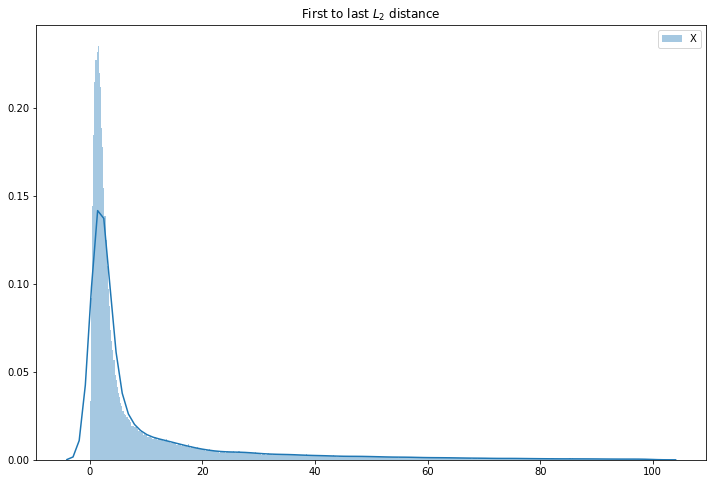

In [171]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_distributions(ax=ax, 
                   data_arrays=[dists_X], 
                   label_array=['X'],
                   min_thresh=0, 
                   max_thresh=100, 
                   title='First to last $L_2$ distance',
                   kde=True)

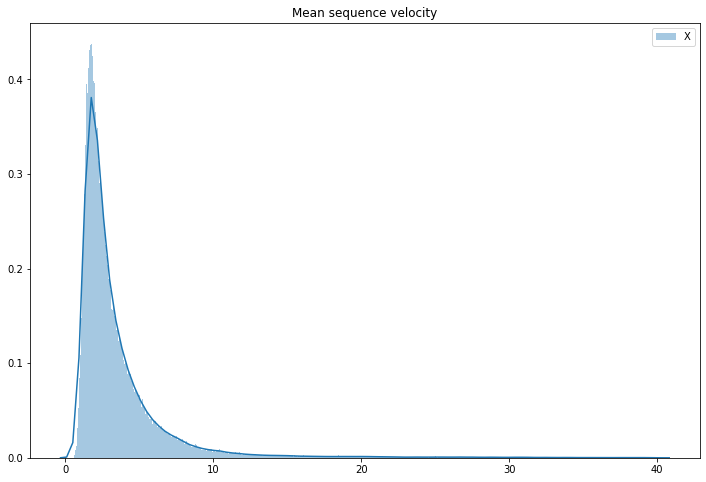

In [172]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_distributions(ax=ax, 
                   data_arrays=[np.nanmean(seq_data_X[:,:,2],axis=1)], 
                   label_array=['X'],
                   min_thresh=0, 
                   max_thresh=40, 
                   title='Mean sequence velocity',
                   kde=True,
                   bins=1000)

In [123]:
zgzg_X = compute_zigzagity(seq_data_X)

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


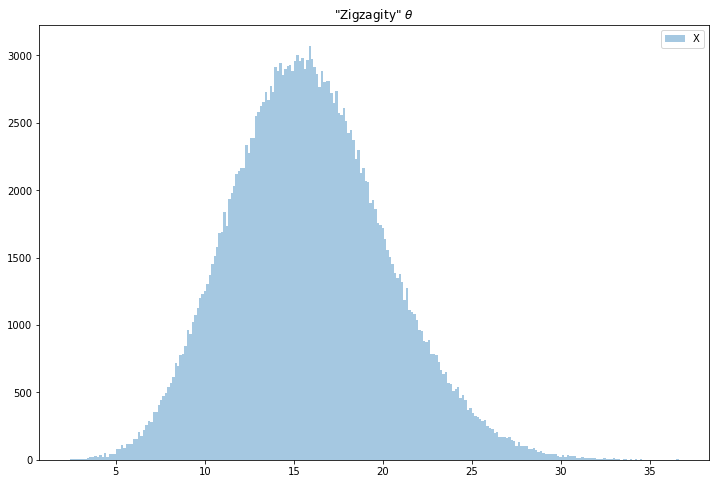

In [124]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_distributions(ax=ax, 
                   data_arrays=[zgzg_X], 
                   label_array=['X'],
                   min_thresh=None, 
                   max_thresh=None, 
                   title='"Zigzagity" $\\theta$',
                   kde=False,
                   bins=250)

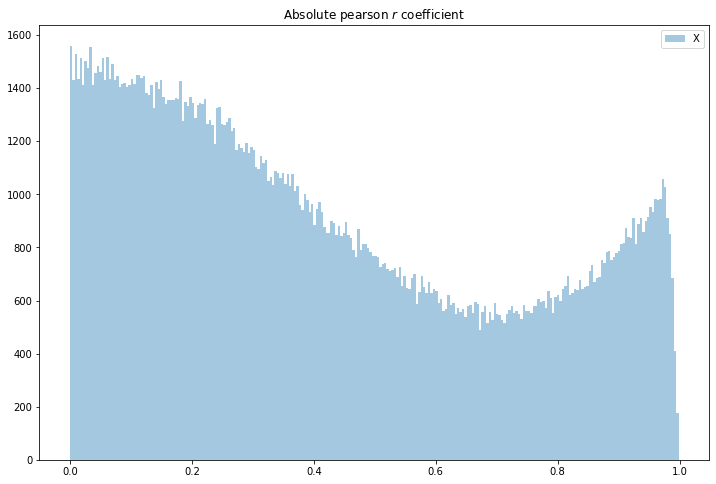

In [187]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_distributions(ax=ax, 
                   data_arrays=[batch_r(seq_data_X)], 
                   label_array=['X'],
                   min_thresh=None, 
                   max_thresh=None, 
                   title='Absolute pearson $r$ coefficient',
                   kde=False,
                   bins=250)

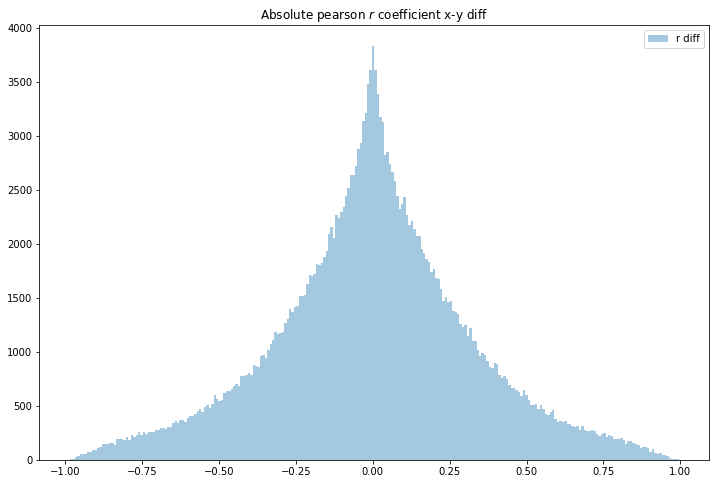

In [189]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_distributions(ax=ax, 
                   data_arrays=[batch_r(seq_data_X)-batch_r(seq_data_Y)], 
                   label_array=['r diff'],
                   min_thresh=None, 
                   max_thresh=None, 
                   title='Absolute pearson $r$ coefficient x-y diff',
                   kde=False,
                   bins=250)